In [1]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Code

In [2]:
def expectile_loss(expectiles,taus,samples):
    '''
    delta = z - q
    loss = E[I(z>q)*tau + (1-I(z>q))*(1-tau)]*(delta^2)
    see Rowland et al. 2019 Definition 3.3.
    '''
    delta = (samples[None, :] - expectiles[:, None])
    indic = np.array(delta >= 0., dtype=np.float32)
    loss = np.mean((indic*taus[:,None] + (1-indic)*(1-taus[:,None]))*delta**2)
    return(loss)

In [3]:
def expectile_loss_fn(expectiles, taus, samples):
    '''
    From Nature Paper Online Code (their notes below)
    It's the Expectile loss function for finding samples this time instead of expectiles.
    see Rowland et al. 2019 eqn. 8

    '''

    # distributional TD model: delta_t = (r + \gamma V*) - V_i
    # expectile loss: delta = sample - expectile
    delta = (samples[None, :] - expectiles[:, None])

    # distributional TD model: alpha^+ delta if delta > 0, alpha^- delta otherwise
    # expectile loss: |taus - I_{delta <= 0}| * delta^2

    # Note: When used to decode we take the gradient of this loss,
    # and then evaluate the mean-squared gradient. That is because *samples* must
    # trade-off errors with all expectiles to zero out the gradient of the
    # expectile loss.
    indic = np.array(delta <= 0., dtype=np.float32)
    grad =  np.abs(taus[:, None] - indic) * delta * -0.5
    return np.mean(np.square(np.mean(grad, axis=-1)))


In [47]:
def quantile_loss_fn(quantiles, taus, samples):
    '''

    '''
    # quantile loss: |taus - I_{delta <= 0}| * |delta|
    
    delta = (samples[None, :] - quantiles[:, None])
    indic = np.array(delta <= 0., dtype=np.float32)
    grad =  np.abs(taus[:, None] - indic) * -0.5 # removing the delta here 
    return np.mean(np.square(np.mean(grad, axis=-1)))


In [48]:
def find_expectiles(expectiles0,taus,samples,method='optimize_scipy',alpha=0.01,
                    max_iters=10000,precision=0.0001,printt=False):

    '''
    Given samples, calculate best fitting expectiles.

    Notes on gradient descent:
        - learning rate needs to be low (0.01 or less) for distributions with rare events
        - in general, I don't the grad descent function, but it's nice to know it works

    '''
    if method=='grad_desc':
        expectiles_n = expectiles0.copy()
        for _i in range(max_iters):
            if printt:
                print(_i)
            expectiles_c = expectiles_n

            # grad over entire dataset (versus at a sample)
            grad = np.mean(grad_expectile_loss(expectiles_c,taus,samples),axis=1)
            expectiles_n = expectiles_c - alpha*np.squeeze(grad)

            step = expectiles_c-expectiles_n
            if np.all(np.abs(step)<=precision):
                expectiles = expectiles_n
                print('here')
                break

        expectiles = expectiles_n

    elif method=='optimize_scipy':
        #import pdb; pdb.set_trace()
        fn_to_minimize = lambda x: expectile_loss(x, taus, samples)
        result = scipy.optimize.minimize(
                    fn_to_minimize, method=None, x0=expectiles0)['x']
        expectiles = result

    return(expectiles)

In [49]:
def impute_distribution(expectiles, taus, minv=-10, maxv=10, method=None,
                 max_samples=100, max_epochs=5, N=25, use_quantiles=False):
    """
    From Nature Paper Online Code (their notes below)
    They say 'Run decoding given reversal points and asymmetries (taus).'

    expectiles were reversal points in their code
    Reversal points = (but they were estimated from neurons)

    """

    ind = list(np.argsort(expectiles))
    points = expectiles[ind]
    tau = taus[ind]
    if use_quantiles:
        loss_fn = quantile_loss_fn
    else:
        loss_fn = expectile_loss_fn

    # Robustified optimization to infer distribution
    # Generate max_epochs sets of samples,
    # each starting the optimization at the best of max_samples initial points.
    sampled_dist = []
    for _ in range(max_epochs):
        # Randomly search for good initial conditions
        # This significantly improves the minima found
        #import pdb; pdb.set_trace()
        samples = np.random.uniform(minv, maxv, size=(max_samples, N))
        fvalues = np.array([loss_fn(points, tau, x0) for x0 in samples])
        #np.array([x0 for x0 in samples])

        # Perform loss minimizing on expectile loss (w.r.t samples)
        x0 = np.array(sorted(samples[fvalues.argmin()]))
        fn_to_minimize = lambda x: loss_fn(points, tau, x)
        result = scipy.optimize.minimize(
            fn_to_minimize, method=method,
            bounds=[(minv, maxv) for _ in x0], x0=x0)['x']

        sampled_dist.extend(result.tolist())

    return np.array(sampled_dist), loss_fn(points, tau, np.array(sampled_dist))

### Expectile Examples

In [50]:
x = np.random.normal(0,1,1000)

In [51]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)

In [52]:
def calc_quantiles(x, taus):
    quantiles = []
    for tau in taus:
        quantiles.append(np.quantile(x, tau))
    return(np.array(quantiles))

In [53]:
quantiles = calc_quantiles(x, taus)
quantiles

array([-1.67926213, -1.08944015, -0.75451304, -0.42025922, -0.16742806,
        0.05312698,  0.35957278,  0.61560768,  1.00139246,  1.68888326])

In [54]:
expectiles = find_expectiles(quantiles, taus, x)
expectiles

array([-1.19208054, -0.73535028, -0.48436451, -0.29117395, -0.12214235,
        0.04060209,  0.21158216,  0.406731  ,  0.66591371,  1.15520544])

In [55]:
x_imputed, loss = impute_distribution(expectiles, taus, minv=-10, maxv=10)
x_imputed_q, loss = impute_distribution(quantiles, taus, minv=-10, maxv=10, use_quantiles=True)

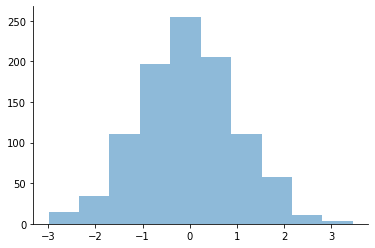

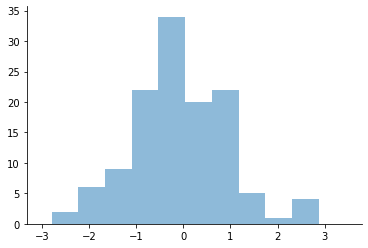

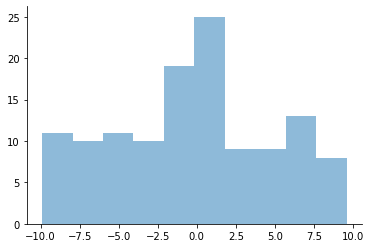

In [56]:
plt.figure()
plt.hist(x, alpha=0.5)
sns.despine()
xlim = plt.gca().get_xlim()

plt.figure()
plt.hist(x_imputed, alpha=0.5)
sns.despine()
plt.xlim(xlim)

plt.figure()
plt.hist(x_imputed_q, alpha=0.5)
sns.despine()
#plt.xlim(xlim)

In [57]:
loss

0.04948724